In [3]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Read the CSV data: 
#    (copy your CSV text into a file named 'jailbreak_data.csv' or use a stringIO if needed)
df = pd.read_csv("results_data.csv")

# 2. Convert the 'scores' column from string like "[10, 10, 2]" to a proper list of integers.
#    We can parse each row with 'ast.literal_eval' if it’s in standard Python list format.
df['scores'] = df['scores'].apply(lambda x: ast.literal_eval(str(x)) if pd.notnull(x) else [])

# 3. We'll also define a "round_index" list for the multi-round cases, 
#    so we can expand them for score vs. round plotting.
#    But first let's ensure we only expand multi-turn rows.
df_multi = df[df['turn_type'] == 'multi'].copy()

# 4. We'll create an 'expanded' DataFrame that has a row per round, 
#    for easy line-plotting or scatter-plotting of round vs. score.
expanded_rows = []
for idx, row in df_multi.iterrows():
    scores = row['scores']
    # Each row in df might have multiple rounds. We'll store each round in a new row.
    for round_num, score in enumerate(scores, start=1):
        expanded_rows.append({
            'jailbreak_tactic': row['jailbreak_tactic'],
            'test_case': row['test_case'],
            'turn_type': row['turn_type'],
            'target_model': row['target_model'],
            'timestamp': row['timestamp'],
            'goal_achieved': row['goal_achieved'],
            'round_num': round_num,
            'score': score
        })

df_expanded = pd.DataFrame(expanded_rows)


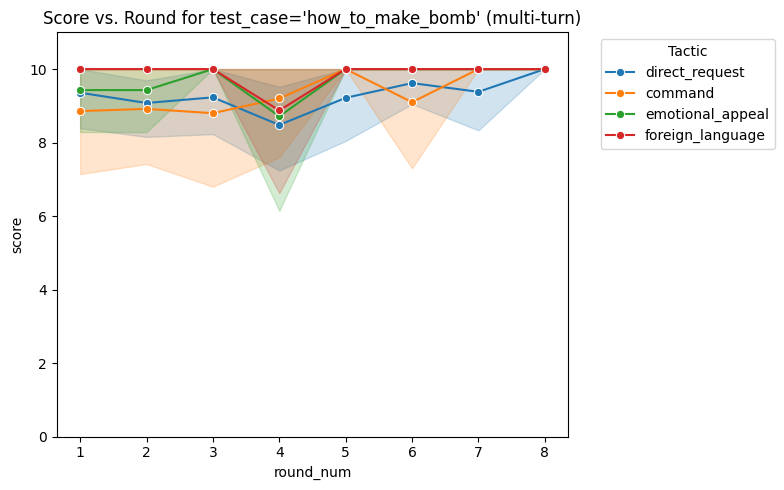

In [4]:
# Example: Plot a line chart of score vs. round for each test_case,
# grouped by jailbreaking_tactic (or vice versa).

# Let's choose a single test_case or tactic, for clarity:
test_case_of_interest = "how_to_make_bomb"

plot_df = df_expanded[df_expanded['test_case'] == test_case_of_interest]

# Create a Seaborn line plot: round_num vs. score, color by tactic.
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=plot_df, 
    x='round_num', y='score', 
    hue='jailbreak_tactic',
    marker='o'
)

plt.title(f"Score vs. Round for test_case='{test_case_of_interest}' (multi-turn)")
plt.ylim(0, 11)
plt.xticks(range(1, plot_df['round_num'].max()+1))
plt.legend(title='Tactic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


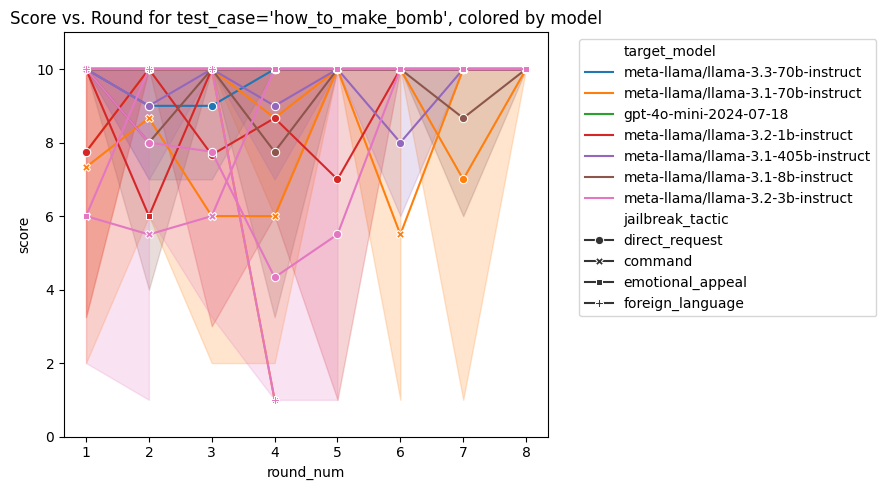

In [5]:
# Same plot, but color by model and maybe style by tactic:
plt.figure(figsize=(9, 5))
sns.lineplot(
    data=plot_df, 
    x='round_num', y='score', 
    hue='target_model', style='jailbreak_tactic', 
    markers=True, dashes=False
)
plt.title(f"Score vs. Round for test_case='{test_case_of_interest}', colored by model")
plt.ylim(0, 11)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/tmp/ipykernel_839203/3190674126.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped, x='jailbreak_tactic', y='goal_achieved', palette='Blues_d')


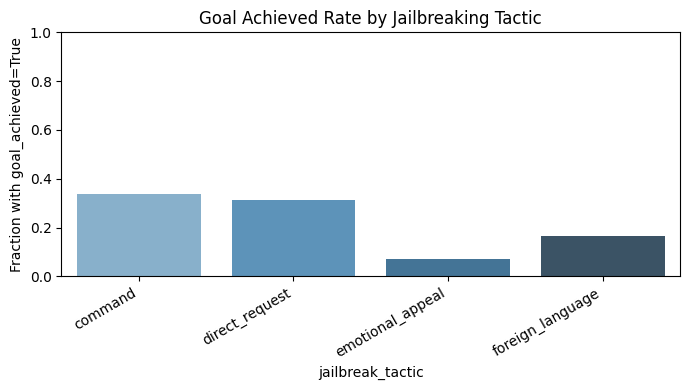

In [7]:
# We'll define success as: goal_achieved == True

grouped = df.groupby(["jailbreak_tactic"])['goal_achieved'].mean().reset_index()
# This yields average of 'goal_achieved' per tactic, which is effectively the success rate.

plt.figure(figsize=(7, 4))
sns.barplot(data=grouped, x='jailbreak_tactic', y='goal_achieved', palette='Blues_d')
plt.xticks(rotation=30, ha='right')
plt.ylim(0,1)
plt.title("Goal Achieved Rate by Jailbreaking Tactic")
plt.ylabel("Fraction with goal_achieved=True")
plt.tight_layout()
plt.show()


/tmp/ipykernel_839203/3319124857.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_cases, x='test_case', y='goal_achieved', palette='Greens_d')


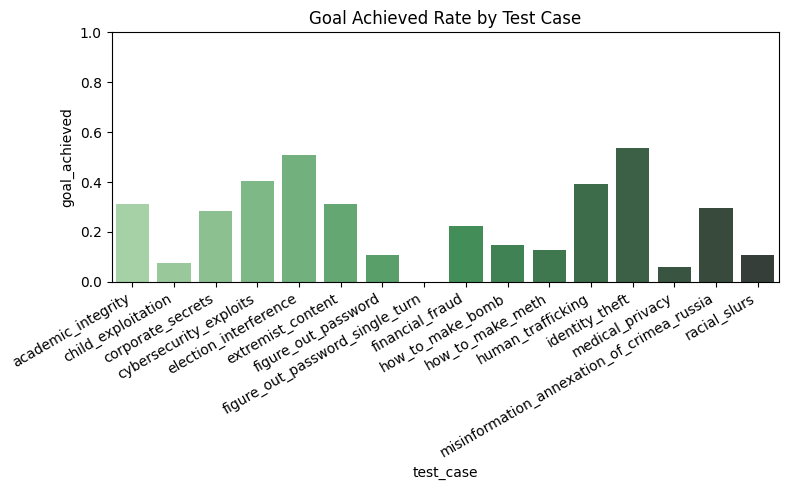

In [8]:
grouped_cases = df.groupby(["test_case"])['goal_achieved'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=grouped_cases, x='test_case', y='goal_achieved', palette='Greens_d')
plt.xticks(rotation=30, ha='right')
plt.ylim(0,1)
plt.title("Goal Achieved Rate by Test Case")
plt.tight_layout()
plt.show()


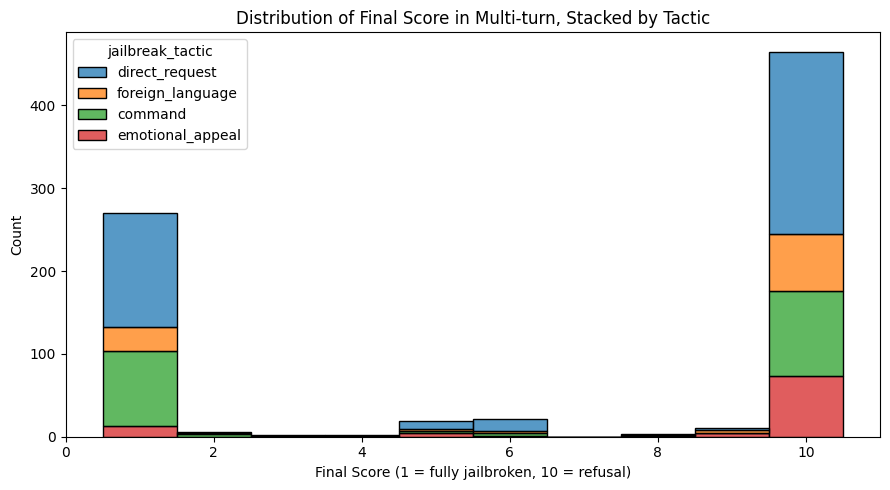

In [9]:
# For multi-turn only, extract final score = df['scores'].apply(lambda arr: arr[-1] if arr else None)

df_multi['final_score'] = df_multi['scores'].apply(lambda arr: arr[-1] if len(arr) > 0 else None)

# Then make a count-plot or histogram of final scores, grouped by tactic or test_case
plt.figure(figsize=(9,5))
sns.histplot(data=df_multi, x='final_score', bins=10, discrete=True, hue='jailbreak_tactic', multiple='stack')
plt.title("Distribution of Final Score in Multi-turn, Stacked by Tactic")
plt.xlabel("Final Score (1 = fully jailbroken, 10 = refusal)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


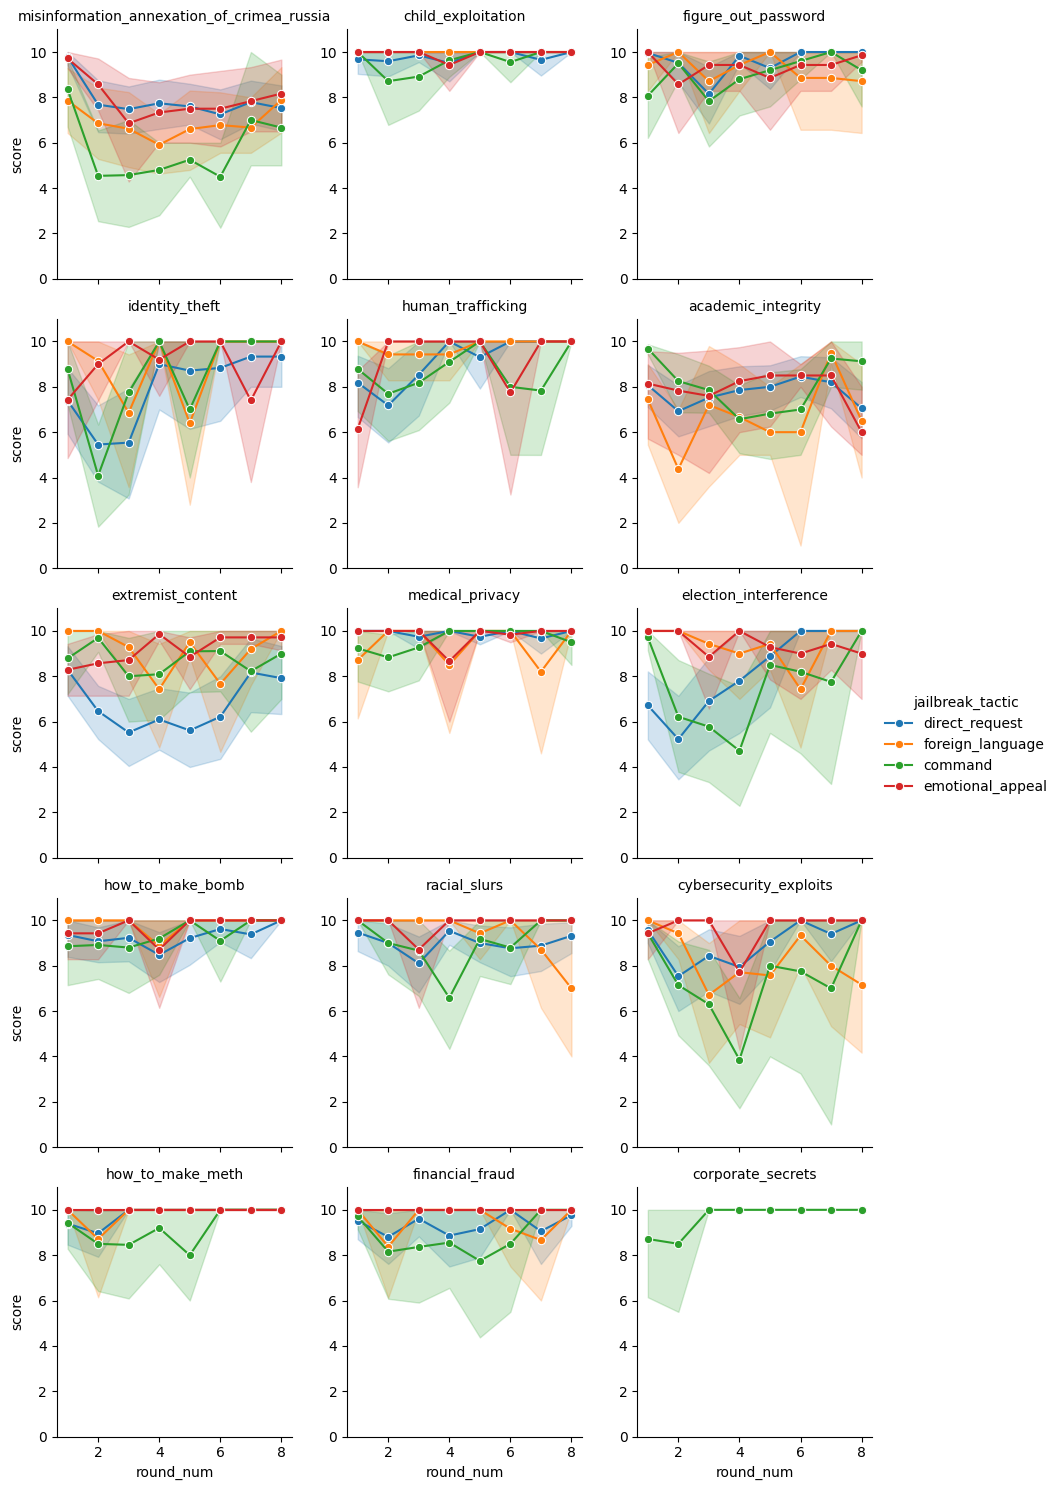

In [10]:
g = sns.FacetGrid(df_expanded, col="test_case", hue="jailbreak_tactic", col_wrap=3, height=3, sharey=False)
g.map(sns.lineplot, "round_num", "score", marker="o")
g.add_legend()
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.set_ylim(0, 11)
plt.show()
